In [2]:
from datetime import date
import numpy as np
import os
import pandas as pd
import time

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Settings

In [3]:
dataDir = "./P1_Foodmart"
transaction_filename = "FoodMart-Transactions-1998.csv"
product_filename = "Product-Lookup.csv"
customer_filename = "Customer-Lookup.csv"

# Input

In [4]:
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))

In [5]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity
0,1/1/1998,12/25/1997,4,2439,10,3
1,1/1/1998,12/28/1997,11,4284,10,3
2,1/1/1998,12/28/1997,12,534,10,3
3,1/1/1998,12/29/1997,14,9743,10,2
4,1/1/1998,12/27/1997,16,3608,10,3


In [6]:
# input: products
df_prod = pd.read_csv(os.path.join(dataDir,product_filename))

In [7]:
df_prod.head()

,product_id,product_brand,product_name,product_sku,product_retail_price,product_cost,product_weight,recyclable,low_fat
0,1,Washington,Washington Berry Juice,90748583674,2.85,0.94,8.39,NaN,NaN
1,2,Washington,Washington Mango Drink,96516502499,0.74,0.26,7.42,NaN,1.0
2,3,Washington,Washington Strawberry Drink,58427771925,0.83,0.40,13.10,1.0,1.0
3,4,Washington,Washington Cream Soda,64412155747,3.64,1.64,10.60,1.0,NaN
4,5,Washington,Washington Diet Soda,85561191439,2.19,0.77,6.66,1.0,NaN


In [8]:
# 只留下 1月到10号的交易
df_trans = df_trans[df_trans['transaction_date'].str.extract(r'^(\d{1,2})')[0].astype(int).between(1, 10)]
df_trans.tail()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity
147214,10/30/1998,10/28/1998,1512,5555,22,3
147215,10/30/1998,10/23/1998,1536,9228,6,2
147216,10/30/1998,10/24/1998,1538,1826,6,4
147217,10/30/1998,10/23/1998,1542,9558,6,4
147218,10/30/1998,10/23/1998,1555,9449,6,4


# Data Preprocessing

## RFM: monetary

In [9]:
# look up the price of the product by its product_id
def lookup_price(product_id, df=df_prod):
    return df_prod[df_prod["product_id"]==product_id]["product_retail_price"].values[0]

In [10]:
df_trans["price"] = [lookup_price(pid) for pid in df_trans["product_id"]]

In [11]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price
0,1/1/1998,12/25/1997,4,2439,10,3,3.64
1,1/1/1998,12/28/1997,11,4284,10,3,3.51
2,1/1/1998,12/28/1997,12,534,10,3,1.54
3,1/1/1998,12/29/1997,14,9743,10,2,1.93
4,1/1/1998,12/27/1997,16,3608,10,3,3.83


In [12]:
df_trans["amount"] = df_trans["quantity"]*df_trans["price"]

In [13]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount
0,1/1/1998,12/25/1997,4,2439,10,3,3.64,10.92
1,1/1/1998,12/28/1997,11,4284,10,3,3.51,10.53
2,1/1/1998,12/28/1997,12,534,10,3,1.54,4.62
3,1/1/1998,12/29/1997,14,9743,10,2,1.93,3.86
4,1/1/1998,12/27/1997,16,3608,10,3,3.83,11.49


In [14]:
m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)
m_value_tmp

/var/folders/9r/6wctl7vd0833sgz91qsg69f80000gp/T/ipykernel_26430/3333363460.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)


customer_id  transaction_date
3            3/29/1998           67.15
             4/17/1998           37.48
6            1/16/1998            6.52
             6/25/1998           40.46
8            10/2/1998           34.13
                                 ...  
10280        8/23/1998           41.13
10281        1/7/1998            49.49
             6/23/1998           66.36
             7/17/1998           88.85
             8/1/1998            42.20
Name: amount, Length: 30362, dtype: float64

1.42 1521.4199999999998


/var/folders/9r/6wctl7vd0833sgz91qsg69f80000gp/T/ipykernel_26430/2462244949.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)


customer_id
3        104.63
6         46.98
8        204.44
9         89.58
10       109.17
          ...  
10275    113.28
10277    169.53
10278    167.24
10280    173.32
10281    246.90
Name: amount, Length: 7532, dtype: float64

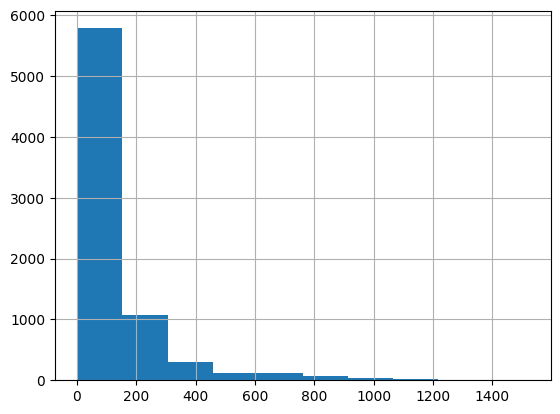

In [15]:
m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)
m_value.hist()
print(m_value.min(), m_value.max())
m_value

## RFM: recency

In [16]:
df_trans["trans_days"] = [(date(1998,12,31)-date(int(d.split("/")[2]),int(d.split("/")[0]),int(d.split("/")[1]))).days for d in df_trans["transaction_date"]]
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount,trans_days
0,1/1/1998,12/25/1997,4,2439,10,3,3.64,10.92,364
1,1/1/1998,12/28/1997,11,4284,10,3,3.51,10.53,364
2,1/1/1998,12/28/1997,12,534,10,3,1.54,4.62,364
3,1/1/1998,12/29/1997,14,9743,10,2,1.93,3.86,364
4,1/1/1998,12/27/1997,16,3608,10,3,3.83,11.49,364


In [17]:
r_trans_tmp = df_trans.groupby("customer_id")['trans_days'].unique()
r_trans_tmp

customer_id
3                                    [277, 258]
6                                    [349, 189]
8        [304, 260, 211, 188, 167, 112, 97, 90]
9                                     [248, 83]
10                         [348, 308, 263, 201]
                          ...                  
10275                      [309, 238, 228, 179]
10277                            [280, 100, 74]
10278                      [307, 288, 282, 247]
10280                 [315, 263, 207, 206, 130]
10281                      [358, 191, 167, 152]
Name: trans_days, Length: 7532, dtype: object

In [18]:
r_value = df_trans.groupby("customer_id")['trans_days'].max()
print(r_value.min(), r_value.max())

62 364


## RFM: frequency

1 37


customer_id
3        2
6        2
8        8
9        2
10       4
        ..
10275    4
10277    3
10278    4
10280    5
10281    4
Name: transaction_date, Length: 7532, dtype: int64

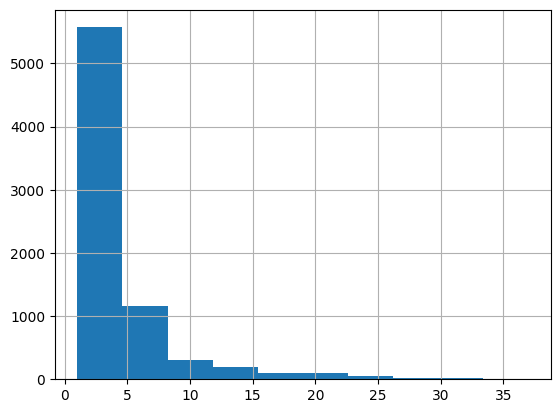

In [19]:
f_value = df_trans.groupby(["customer_id"])["transaction_date"].nunique()
f_value.hist()
print(f_value.min(), f_value.max())
f_value

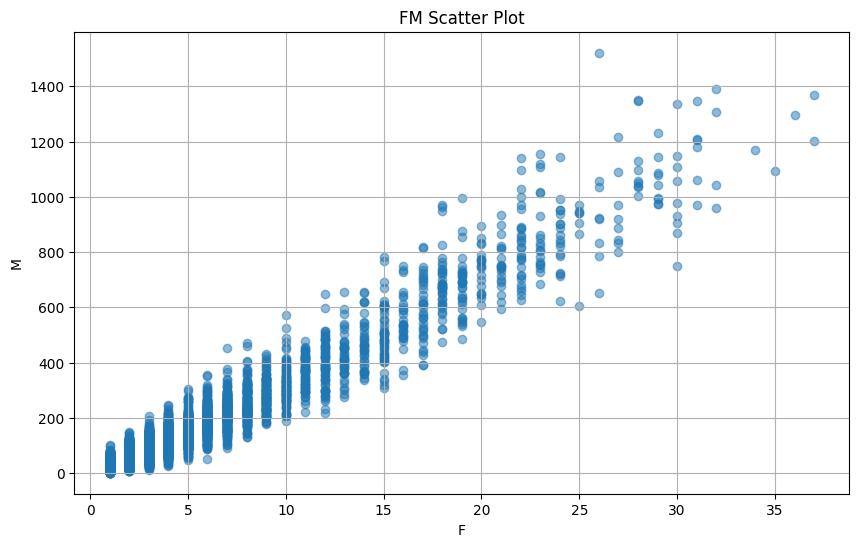

In [20]:
common_ids = f_value.index.intersection(m_value.index)

x = f_value.loc[common_ids]
y = m_value.loc[common_ids]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('F')
plt.ylabel('M')
plt.title('FM Scatter Plot')
plt.grid(True)
plt.show()


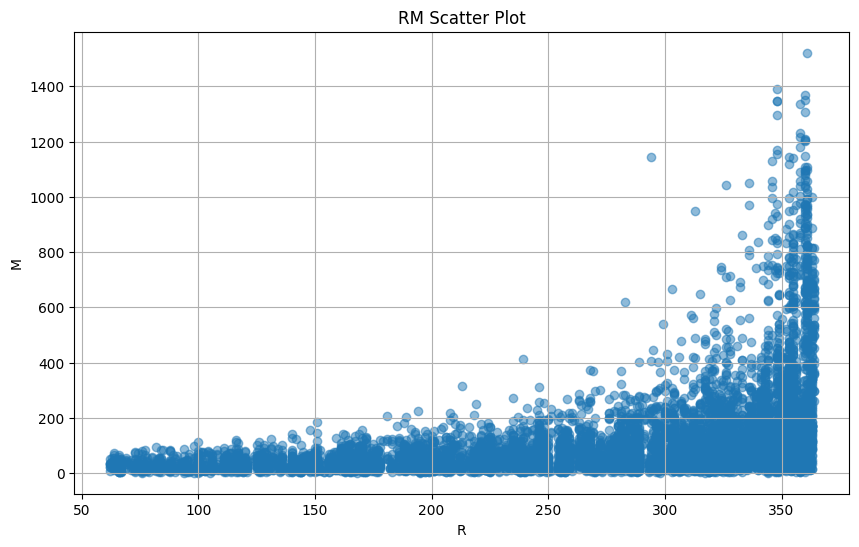

In [21]:
common_ids = r_value.index.intersection(m_value.index)

x = r_value.loc[common_ids]
y = m_value.loc[common_ids]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('R')
plt.ylabel('M')
plt.title('RM Scatter Plot')
plt.grid(True)
plt.show()


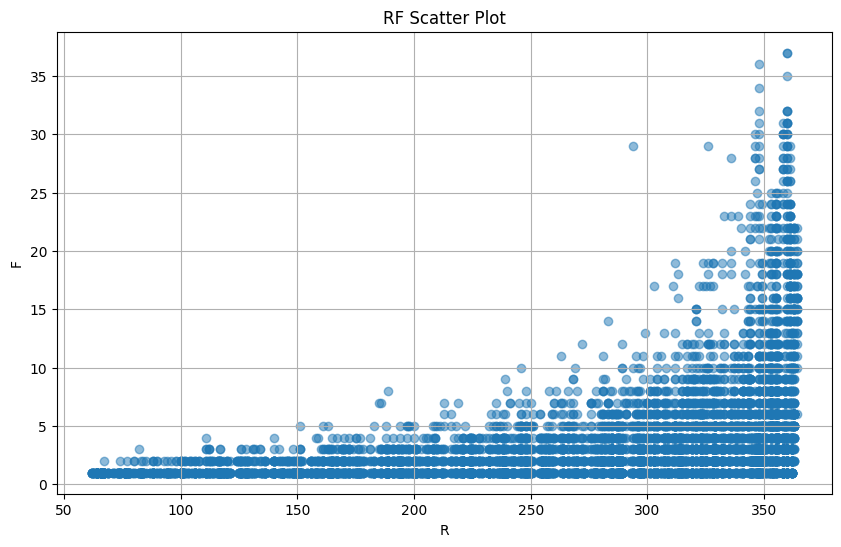

In [22]:
common_ids = r_value.index.intersection(f_value.index)

x = r_value.loc[common_ids]
y = f_value.loc[common_ids]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('R')
plt.ylabel('F')
plt.title('RF Scatter Plot')
plt.grid(True)
plt.show()


# Observation: RFM 

In [23]:
# Series: transaction_date_series, amount_series, third_series
common_ids = f_value.index & m_value.index & r_value.index

df = pd.DataFrame({
    'r': r_value.loc[common_ids],
    'm': m_value.loc[common_ids],
    'f': f_value.loc[common_ids]
})


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
K_range = range(2, 31)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # inertia_ 就是 SSE


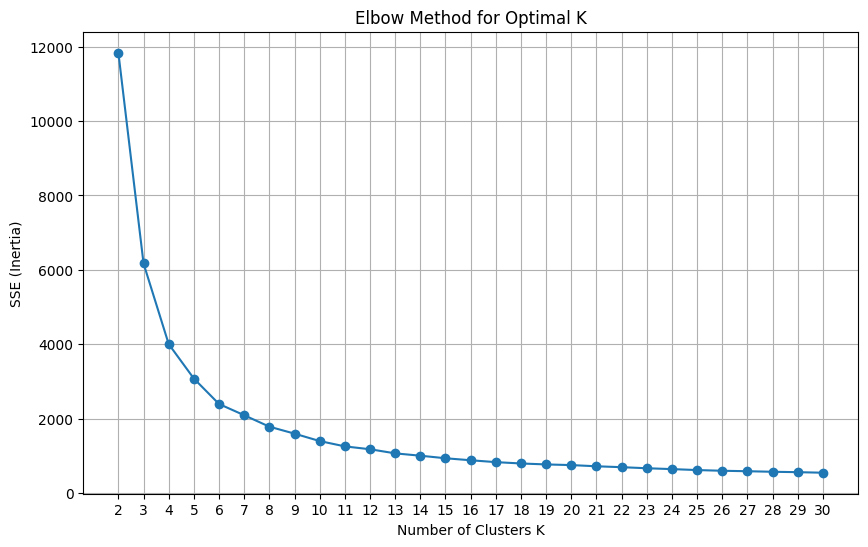

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o')
plt.xticks(K_range)
plt.xlabel('Number of Clusters K')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


In [27]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [28]:
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# 建立 DataFrame 表示中心點
centroids_df = pd.DataFrame(centroids_original, columns=['R', 'M', 'F'])

# 依照 M（Monetary）降冪排序
centroids_df = centroids_df.sort_values(by='M', ascending=False).reset_index(drop=True)

# 列出結果
for i, row in centroids_df.iterrows():
    print(f"C{i+1}: R={row['R']:.2f}、F={row['F']:.2f}、M={row['M']:.2f}")

C1: R=354.04、F=21.17、M=782.83
C2: R=336.80、F=8.92、M=289.41
C3: R=327.21、F=2.93、M=84.83
C4: R=237.47、F=2.00、M=58.54
C5: R=127.91、F=1.35、M=37.92


In [31]:
target_cluster_center = centroids_df.iloc[0]
R, F, M = target_cluster_center['R'], target_cluster_center['F'], target_cluster_center['M']
print(f"中心點 C1: R={R:.2f}, F={F:.2f}, M={M:.2f}")

# kmeans.labels_ 對應每個客戶分到哪一群
cluster_labels = pd.Series(kmeans.labels_, index=df.index)

# 找到屬於此群的所有 customer_id
target_cluster_id = cluster_labels.value_counts().idxmax()  # 金額最高那群是 C1，通常是最多營收者
target_customers = cluster_labels[cluster_labels == target_cluster_id]

print(f"此群顧客總人數：{len(target_customers)}")
rfm_group = df.loc[target_customers.index]

R_min, R_max = rfm_group['r'].min(), rfm_group['r'].max()
F_min, F_max = rfm_group['f'].min(), rfm_group['f'].max()
M_min, M_max = rfm_group['m'].min(), rfm_group['m'].max()

print(f"R: [{R_min}, {R_max}]")
print(f"F: [{F_min}, {F_max}]")
print(f"M: [{M_min}, {M_max}]")


中心點 C1: R=354.04, F=21.17, M=782.83
此群顧客總人數：2966
R: [268, 363]
F: [1, 7]
M: [1.42, 246.9]


K=5